In [18]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import silhouette_score


In [19]:
df = pd.read_csv('titanic3.csv')

df["ageNull"] = df["age"].isnull().astype(int)

Imute Missing Data

In [20]:
numeric_cols = ["age","fare", "pclass", "sibsp", "parch"]


X_num = df[numeric_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)


imputer = KNNImputer(
    n_neighbors=5,          
    weights="uniform"      
)

X_imputed = imputer.fit_transform(X_scaled)

X_filled = scaler.inverse_transform(X_imputed)
df_imputed = pd.DataFrame(X_filled, columns=numeric_cols, index=df.index)

df["AgeImputed"] = df_imputed["age"]
df.drop('age', axis=1, inplace=True)
df.drop('cabin', axis=1, inplace=True)
df.drop('body', axis=1, inplace=True)
df.drop('boat', axis=1, inplace=True)
df.drop('home.dest', axis=1, inplace=True)



Create Title Column

In [21]:
df["Title"] = (
    df["name"]
    .str.extract(r",\s*([^\.]+)\.", expand=False)
    .str.strip()
)

df.drop('name', axis=1, inplace=True)


Mapping Text Data To Numeric

In [22]:
df["sex"] = df["sex"].map({"male": 1, "female": 0})


df = pd.get_dummies(df,
                    columns=["embarked"],
                    prefix="emb",
                    drop_first=True,
                    dtype=float)

df = pd.get_dummies(df,
                    columns=["Title"],
                    prefix="title",
                    drop_first=True,
                    dtype=float)

df["ticket_prefix"] = (
    df["ticket"]
      .str.extract(r"^([A-Za-z\.\/]+)", expand=False)   
      .str.replace(r"[\.\/]", "", regex=True)           
      .fillna("NONE")                                   
)

df["ticket_number"] = (
    df["ticket"]
      .str.extract(r"(\d+)$", expand=False)
      .astype(float)
      .fillna(0.0)
)


df = pd.get_dummies(df,
                    columns=["ticket_prefix"],
                    prefix="tkt",
                    drop_first=True,
                    dtype=float)

df.drop(columns=["ticket"], inplace=True)

In [23]:
df_clean = df.dropna().reset_index(drop=True)
df.drop(columns=["survived"], inplace=True)


X_scaled = scaler.fit_transform(df_clean)

UMAP Dimentionality Reduction

In [24]:
reducer = umap.UMAP(
    n_neighbors=30,     
    min_dist=0.00,       
    n_components=2     
)


X_umap = reducer.fit_transform(X_scaled)



/Users/masongill/Desktop/Misc/desktop_folders/MachineLearning/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


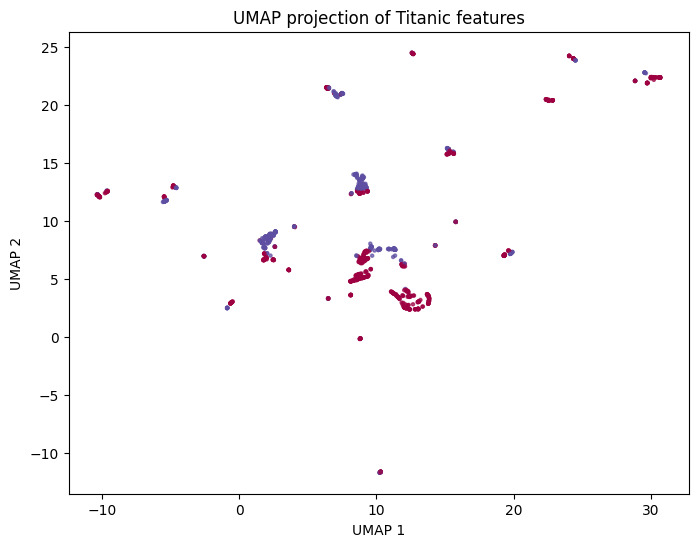

In [25]:
df_clean["UMAP1"], df_clean["UMAP2"] = X_umap[:,0], X_umap[:,1]
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=df_clean["survived"],    
    cmap="Spectral",           
    s=5,                        
    alpha=0.7
)
plt.title("UMAP projection of Titanic features")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [26]:
best_db = None
best_score = -1
best_params = None

for eps in np.arange(0.1, 1.1, 0.1):
    for ms in range(3, 11):
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_umap)
        if len(set(labels)) > 1:
            score = silhouette_score(X_umap, labels)
            if score > best_score:
                best_score, best_params, best_db = score, (eps, ms), db

print(f"Best DBSCAN Silhouette: {best_score:.4f} with eps={best_params[0]}, min_samples={best_params[1]}")

Best DBSCAN Silhouette: 0.7461 with eps=0.5, min_samples=8


In [27]:
coords = df_clean[["UMAP1", "UMAP2"]].values
db = DBSCAN(eps=0.3, min_samples=3)
df_clean["cluster"] = db.fit_predict(coords)

In [28]:
cluster_stats = (
    df_clean.groupby("cluster")["survived"]
            .agg(count="count", survival_rate="mean")
            .reset_index()
)
print(cluster_stats)

    cluster  count  survival_rate
0        -1      9       0.666667
1         0    101       0.980198
2         1     56       0.500000
3         2     92       0.206522
4         3    144       0.784722
5         4     16       1.000000
6         5     41       0.268293
7         6     49       0.938776
8         7     19       0.315789
9         8      8       0.500000
10        9     22       0.454545
11       10     34       0.029412
12       11     60       0.000000
13       12     26       0.038462
14       13     17       0.000000
15       14      8       0.000000
16       15     30       1.000000
17       16      9       0.555556
18       17      6       0.000000
19       18      5       0.400000
20       19     15       0.200000
21       20     22       0.818182
22       21      8       0.125000
23       22     14       0.571429
24       23     36       0.055556
25       24     35       0.742857
26       25     19       0.105263
27       26     38       0.131579
28       27   

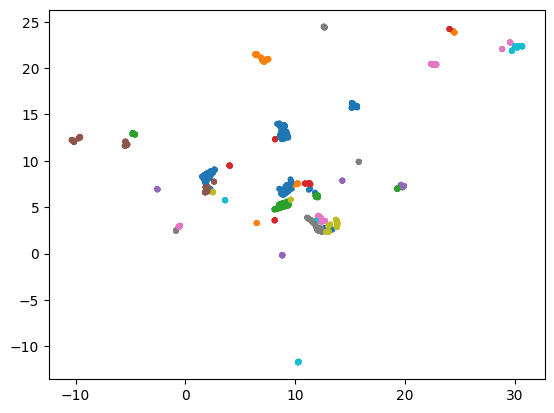

In [29]:

plt.scatter(coords[:,0], coords[:,1],
            c=df_clean["cluster"], cmap="tab10", s=10)
plt.show()

In [30]:
df_clean["cluster"] = labels
surv_rate = df_clean.groupby("cluster")["survived"].mean()


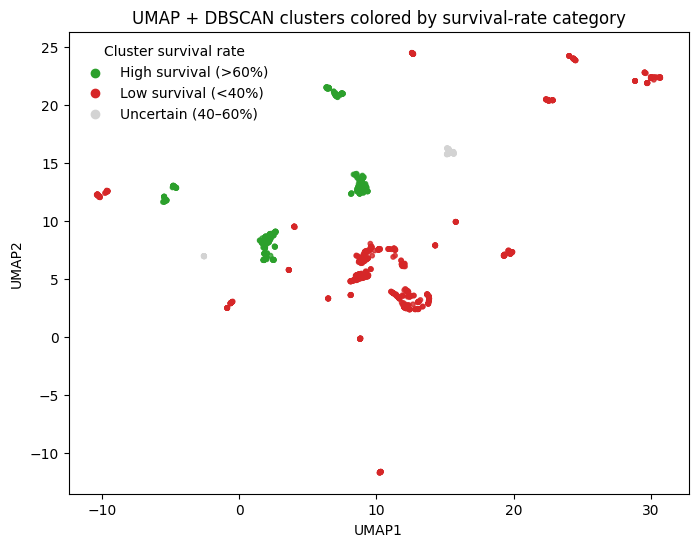

In [31]:
cluster_to_color = {}
for cluster_id, rate in surv_rate.items():
    if rate > 0.6:
        cluster_to_color[cluster_id] = "tab:green"   
    elif rate < 0.4:
        cluster_to_color[cluster_id] = "tab:red"     
    else:
        cluster_to_color[cluster_id] = "lightgrey"  

point_colors = df_clean["cluster"].map(cluster_to_color)

plt.figure(figsize=(8,6))
plt.scatter(
    coords[:,0],
    coords[:,1],
    c=point_colors,
    s=10,
    alpha=0.8
)
for label, color, name in [
    (">0.6", "tab:green", "High survival (>60%)"),
    ("<0.4", "tab:red",   "Low survival (<40%)"),
    ("mid",  "lightgrey","Uncertain (40–60%)")
]:
    plt.scatter([], [], c=color, label=name)
plt.legend(frameon=False, title="Cluster survival rate")
plt.title("UMAP + DBSCAN clusters colored by survival-rate category")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()